# The Battle of Paris Neighborhoods
### IBM/Coursera Data Science Capstone Project

Autor: Sebastien SIME
___

## Table of contents: <a name="table"></a>
<div class="alert alert-block alert-info">
    
1. [Introduction: Business Problem](#intro)
2. [Methodology](#meth)
3. [General idea about Paris](#exploration)
4. [Boroughs general reputation](#reputation_accessibility)
5. [Paris Neighborhoods exploration](#venues)
6. [Results and discussion](#discussion)
7. [Conclusion](#conclusion)
    
</div>

## 1. Introduction: Business Problem <a name="intro"></a>                                              

This work is about using data on internet and Foursquare location data to advice on potential places to open a restaurant in Paris.

Taking the case of an undertaker who wants to open a restaurant, a data science approach can be used in combination to a defined set of parameters to advice on possible locations. Regarding the place itself, some of the relevant parameters that could be used are:

* Accessibility
* The general boroughs' reputation
* The global neighborhoods' environment in terms of famous venues
* Level of restaurant competition

These parameters will allow to provide a general understanding of Paris which will allow the business owner to build a strategy.

## 2. Methodology <a name="meth"></a>

Finding the best possible place begin by having a general idea about Paris. To address this issue, a web page ranking some of the most french enjoyable cities will be used.

Next, we may wonder about the general accessibility and reputation of Paris' boroughs. Here again a web page will provide some ratings about Paris boroughs.

Having a general idea of Paris and it borough we will then used the Foursquare API in combination to some other web pages to build a segmentation of Paris neighbourhoods. The segmentation will allow to assess in each clusters the level of restaurant competition.

## 3. General idea about Paris <a name="exploration"></a>

As a broad presentation, the city of Paris is made up of twenty (20) boroughs with four (4) neighborhoods in each borough (for details follow the [link](https://fr.m.wikipedia.org/wiki/Liste_des_quartiers_administratifs_de_Paris)). So from the start we have eighty possibilities in terms of neighborhoods.

Apart from the fact that Paris is the french Capital, what is it to know about the french city? To answer this question, let's web-scraped http://www.linternaute.com with the defined functions below to extract a rank of most enjoyable french cities with more than 10000 people.

Below we have a screen shot of the web page:

<img src="linternaute.JPG">

In [128]:
# Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests # import request for beautiful soup
from bs4 import BeautifulSoup # import request for beautiful soup

In [3]:
# Function to extract a table on one page
def getTable(url):
    # Libraries:
    from bs4 import BeautifulSoup
    import requests
    
    req = requests.get(url)
    soup = BeautifulSoup(req.text, "html.parser")

    # To find a table
    table = soup.table # select the table in the html
    table_rows = table.find_all('tr') # select all the row (tr r for row)
    table_columns = [i.text.rstrip() for i in table.find_all('th')] # select all the header of each columns
    
    # Built a list of lists with all the data
    rows = []
    for tr in table_rows:
        td = tr.find_all('td') # select all the data
        rows.append( [i.text.rstrip() for i in td] ) # extract the text from the data
    
    # return the data frame:
    df = pd.DataFrame(rows, columns = table_columns)
    df = df.drop([0]).reset_index()
    
    # Add two new columns
    table_links = table.find_all('a') # select all the links in the table structure
    links_columns = [ table_links[i]['href'] for i in range((len(table_links))) ] # extract links
    city_names = [ table_links[i].text for i in range((len(table_links))) ] # extract city names
    #
    df['Ville_2'] = city_names
    df['links'] = links_columns
    #
    df = df.drop(columns = 'index')
    
    return (df)
#

In [6]:
# Function to extract the tables for each pages
def cityRank_v2(url):
    
    # create the first table:
    df = getTable(url)
    
    # extract pagination end url:
    req = requests.get(url)
    soup = BeautifulSoup(req.text, "html.parser")
    #
    soup_pagination = soup.find_all("a",{"class":"pagination"})
    pagenum= len(soup_pagination)
    
    # first concat:
    urlp1 = 'http://www.linternaute.com/'
    urlp2 = soup_pagination[2]['href'] # 2 - page 2:10
    #
    # url concatenation
    URL = urlp1 + urlp2
    #
    df1 = getTable(URL)
    #
    df = pd.concat([df, df1]).reset_index()
    #
    df = df.drop(columns = 'index')
    
    for i in range(3, 53):
        urlp1 = 'http://www.linternaute.com/ville/c-villes-les-plus-agreables/'
        urlp3 = '?w=795%2C1%3B796%2C1%3B797%2C1%3B798%2C1%3B799%2C1%3B800%2C1%3B801%2C1%3B802%2C1%3B803%2C1%3B804%2C1%3B805%2C1%3B806%2C1%3B807%2C1%3B808%2C1%3B809%2C1%3B810%2C1%3B811%2C1%3B812%2C1%3B813%2C1%3B814%2C1'
        # data-api
        #urlp2 = soup_pagination[i]['href'] # 2 - page 2:10
        # url concatenation
        URL = urlp1 + str(i) + urlp3
        #
        df1 = getTable(URL)
        #
        df = pd.concat([df, df1]).reset_index()
        #
        df = df.drop(columns = 'index')
    
    # Adding the lat & lng column:
    lat = []
    lng = []
    #
    for row in range(df.shape[0]):
        try:
            url2 = df.loc[row, 'links']
            data = pd.read_html(url2)
            lat.append(data[3].iloc[3, 1]) # Latitude
            lng.append(data[3].iloc[4, 1]) # Longitude
        except:
            lat.append(0) # Latitude
            lng.append(0) # Longitude
    #
    df['latitude'] = lat
    df['longitude'] = lng
    
    return (df)
#

In [7]:
# Call of the previously defined functions
url= 'http://www.linternaute.com/ville/c-villes-les-plus-agreables?w=795%2C1%3B796%2C1%3B797%2C1%3B798%2C1%3B799%2C1%3B800%2C1%3B801%2C1%3B802%2C1%3B803%2C1%3B804%2C1%3B805%2C1%3B806%2C1%3B807%2C1%3B808%2C1%3B809%2C1%3B810%2C1%3B811%2C1%3B812%2C1%3B813%2C1%3B814%2C1'
df = cityRank_v2(url) # Can take few minutes to complete
df.head()

,Rang,Ville,Note,Climat : ensoleillement,Climat : précipitations,Environnement : ville fleurie,Environnement : forêts,"Environnement : plan d'eau, cours d'eau, mer, estuaire...",Environnement : zone naturelle,Immobilier : densité de population,...,Santé : dentistes,Education : écoles,Education : % de réussite au bac,Pollution : particules en suspension,Pollution : dioxyde d'azote (NO2),,Ville_2,links,latitude,longitude
0,1,L'Isle-Adam,"16,85 / 20",nc,"366,10 mm/an",3 fleurs,"948,41 ha","51,31 ha",0 ha,"819,88 hab/km²",...,"1,80 ‰","0,65 ‰",100 %,nc,nc,,L'Isle-Adam,http://www.linternaute.com/ville/l-isle-adam/v...,49.1072,2.23436
1,2,Fontainebleau,"16,79 / 20",693 h/an,"305,90 mm/an",2 fleurs,"16 186,32 ha","6,72 ha","323,25 ha","87,03 hab/km²",...,"1,80 ‰","0,80 ‰","93,99 %",nc,nc,,Fontainebleau,http://www.linternaute.com/ville/fontainebleau...,48.4067,2.68031
2,3,Porto-Vecchio,"16,38 / 20",904 h/an,"340,70 mm/an",nc,"4 042,78 ha","365,22 ha","7 989,01 ha","70,12 hab/km²",...,"1,69 ‰","0,68 ‰","88,64 %",nc,nc,,Porto-Vecchio,http://www.linternaute.com/ville/porto-vecchio...,41.5925,9.25363
3,4,Ploërmel,"16,11 / 20",728 h/an,"247,40 mm/an",3 fleurs,"414,58 ha","52,69 ha","21,28 ha","188,37 hab/km²",...,"0,63 ‰","0,42 ‰","97,58 %",nc,nc,,Ploërmel,http://www.linternaute.com/ville/ploermel/vill...,47.9222,-2.38314
4,5,Digne-les-Bains,"15,95 / 20",867 h/an,381 mm/an,3 fleurs,"4 545,72 ha",0 ha,"4 633,64 ha","138,77 hab/km²",...,"1,17 ‰","0,74 ‰","91,01 %",nc,nc,,Digne-les-Bains,http://www.linternaute.com/ville/digne-les-bai...,44.0909,6.2359


In [14]:
df.shape

(1025, 28)

We have in the rank about 1000 french cities.

In [41]:
# Store the old columns names
old_col = df.columns
# columns' names english translation
new_col = ['rank', 'city', 'Notation', 'sunlight',
       'précipitations', 'flower_city',
       'forest',
       'water',
       'natural_zone', 'density',
       'house_percentage', 'real_estate_price',
       'unemployment_rate', 'employment_CDIcontract',
       'shop_rate', 'pool', 'cinemas',
       'general_practitioner', 'dental_professional',
       'schools', 'Bachelor_degree_success_rate',
       'pollution_particles',
       'pollution_NO2', '', 'city_2', 'links', 'latitude',
       'longitude']
# modify the columns names
french_most_enjoyable_city = df
french_most_enjoyable_city.columns = new_col
french_most_enjoyable_city.head()

,rank,city,Notation,sunlight,précipitations,flower_city,forest,water,natural_zone,density,...,dental_professional,schools,Bachelor_degree_success_rate,pollution_particles,pollution_NO2,,city_2,links,latitude,longitude
0,1,L'Isle-Adam,"16,85 / 20",nc,"366,10 mm/an",3 fleurs,"948,41 ha","51,31 ha",0 ha,"819,88 hab/km²",...,"1,80 ‰","0,65 ‰",100 %,nc,nc,,L'Isle-Adam,http://www.linternaute.com/ville/l-isle-adam/v...,49.1072,2.23436
1,2,Fontainebleau,"16,79 / 20",693 h/an,"305,90 mm/an",2 fleurs,"16 186,32 ha","6,72 ha","323,25 ha","87,03 hab/km²",...,"1,80 ‰","0,80 ‰","93,99 %",nc,nc,,Fontainebleau,http://www.linternaute.com/ville/fontainebleau...,48.4067,2.68031
2,3,Porto-Vecchio,"16,38 / 20",904 h/an,"340,70 mm/an",nc,"4 042,78 ha","365,22 ha","7 989,01 ha","70,12 hab/km²",...,"1,69 ‰","0,68 ‰","88,64 %",nc,nc,,Porto-Vecchio,http://www.linternaute.com/ville/porto-vecchio...,41.5925,9.25363
3,4,Ploërmel,"16,11 / 20",728 h/an,"247,40 mm/an",3 fleurs,"414,58 ha","52,69 ha","21,28 ha","188,37 hab/km²",...,"0,63 ‰","0,42 ‰","97,58 %",nc,nc,,Ploërmel,http://www.linternaute.com/ville/ploermel/vill...,47.9222,-2.38314
4,5,Digne-les-Bains,"15,95 / 20",867 h/an,381 mm/an,3 fleurs,"4 545,72 ha",0 ha,"4 633,64 ha","138,77 hab/km²",...,"1,17 ‰","0,74 ‰","91,01 %",nc,nc,,Digne-les-Bains,http://www.linternaute.com/ville/digne-les-bai...,44.0909,6.2359


Let's find out the genral information about the city of Paris:

In [43]:
# small resume of Paris compared to other major french cities:
french_most_enjoyable_city.iloc[721, :]

rank                                                                          722
city                                                                        Paris
Notation                                                               11,26 / 20
sunlight                                                                 693 h/an
précipitations                                                       366,40 mm/an
flower_city                                                                    nc
forest                                                                       0 ha
water                                                                   248,94 ha
natural_zone                                                                 0 ha
density                                                         20 934,42 hab/km²
house_percentage                                                           0,97 %
real_estate_price                                                      9 450 €/m²
unemployment_rat

Looking at the this short description here is some points that could be stressed:

* Paris is at the place 722 with an assigned general grade of about 11 over 20 (a little behind Marseille or Nice)
* The house percentage is very small
* There is actually not enough green zones
* There is about 1 general practitioner for 1000 people
* Pollution seems high
* And finally the real estate price is high

So in contrast to the high density, Paris is not (according to the survey) among the first 100 most enjoyable french cities **to live in**. Among the major french cities, Paris is behind the city of Marseille and Nice.

In [51]:
pp_cities = ['Paris', 'Marseille', 'Lyon', 'Toulouse', 'Nice'] # The 5 major French cities
cond = french_most_enjoyable_city['city'].isin(pp_cities)
french_most_enjoyable_city.loc[cond, :]

,rank,city,Notation,sunlight,précipitations,flower_city,forest,water,natural_zone,density,...,dental_professional,schools,Bachelor_degree_success_rate,pollution_particles,pollution_NO2,,city_2,links,latitude,longitude
465,466,Marseille,"12,42 / 20",963 h/an,"282,80 mm/an",nc,"1 914,90 ha","122,58 ha","8 124,02 ha","3 580,90 hab/km²",...,"0,88 ‰","0,59 ‰","84,79 %",29 ug,"52,50 ug",,Marseille,http://www.linternaute.com/ville/marseille/vil...,43.2977,5.37479
531,532,Nice,"12,15 / 20",843 h/an,"445,10 mm/an",4 fleurs,"1 097,30 ha","45,55 ha","236,94 ha","4 762,54 hab/km²",...,"1,23 ‰","0,52 ‰","87,88 %","26,67 ug",37 ug,,Nice,http://www.linternaute.com/ville/nice/ville-06088,43.712,7.23827
721,722,Paris,"11,26 / 20",693 h/an,"366,40 mm/an",nc,0 ha,"248,94 ha",0 ha,"20 934,42 hab/km²",...,"1,11 ‰","0,37 ‰","91,08 %","29,78 ug","53,10 ug",,Paris,http://www.linternaute.com/ville/paris/ville-7...,48.8589,2.33828
778,779,Toulouse,"10,93 / 20",641 h/an,"392,30 mm/an",3 fleurs,"196,47 ha","297,42 ha","107,64 ha","3 989,36 hab/km²",...,"0,93 ‰","0,47 ‰","89,40 %",22 ug,37 ug,,Toulouse,http://www.linternaute.com/ville/toulouse/vill...,43.5964,1.43167
879,880,Lyon,"10,05 / 20",636 h/an,379 mm/an,nc,0 ha,"325,07 ha",0 ha,"10 722,27 hab/km²",...,"0,83 ‰","0,41 ‰","92,03 %",26 ug,"37,50 ug",,Lyon,http://www.linternaute.com/ville/lyon/ville-69123,45.7612,4.83287


## 4. Boroughs general reputation <a name="reputation_accessibility"></a>

### Getting the Data:

Now that we know a little more about Paris, let's look at the boroughs in regards to one another.

To address this point, we will use the web page https://www.parisenigmes.com/guide-arrondissement-paris which provide general grades related to the twenty (20) boroughs. Excellent grades could be considered above 7.5 (/10) and grades below 5 small enough.

The grades have been provided by people so a high grades are awarded to criteria that people valued much and vice versa. For example, In the firt borough (Paris 1), people value most the mass transit (transport) coverage and are not satisfied with the environment neighbourhood policy (green zone, pullution or city cleanliness, etc.).

In [7]:
# required libraries:
import pandas as pd
import folium

In [3]:
# Store the url:
link_boroughs = 'https://www.parisenigmes.com/guide-arrondissement-paris'

# Extract the table and store the data in a data frame
paris_boroughs_grades = pd.read_html(link_boroughs)
paris_boroughs_grades_df = paris_boroughs_grades[0]

In [4]:
# Redefine the columns names: (English translation)
paris_boroughs_grades_df.columns = ['Borough', 'Life_quality', 'Culture', 'Mass_transit', 'Shops', 'Environment', 'Security']
# View an extract of the data frame
paris_boroughs_grades_df.head()

,Borough,Life_quality,Culture,Mass_transit,Shops,Environment,Security
0,Paris 1,6.50,8.70,9.30,8.30,4.40,5.60
1,Paris 2,5.63,7.81,8.00,8.19,3.00,5.88
2,Paris 3,8.06,9.25,8.00,9.31,6.25,8.63
3,Paris 4,6.44,7.94,8.44,7.31,7.50,7.88
4,Paris 5,8.29,8.33,8.50,8.17,8.67,8.21


In [59]:
paris_boroughs_grades_df.shape

(20, 7)

In [6]:
paris_boroughs_grades_df.dtypes

Borough          object
Life_quality    float64
Culture         float64
Mass_transit    float64
Shops           float64
Environment     float64
Security        float64
dtype: object

In [67]:
paris_boroughs_grades_df.isna().sum()

Borough          0
Life_quality     0
Culture          0
Mass_transit     0
Shops            0
Environnement    0
Security         0
dtype: int64

The dataset is clean, with the same format and can be used as is.

### Data Exploration:

Let's study the correlation in the dataset:

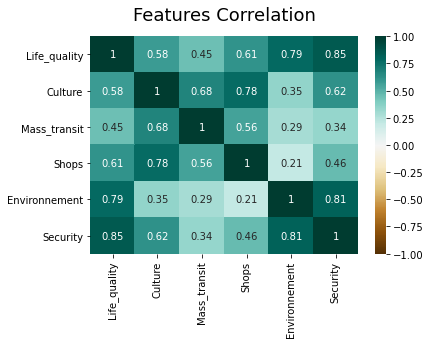

In [84]:
# Create teh correlation heatmap:
import seaborn as sns
#plt.figure(figsize=(8, 12))
#
corr_heatmap = sns.heatmap(paris_boroughs_grades_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
#
corr_heatmap.set_title('Features Correlation', fontdict={'fontsize':18}, pad=16);

The is a rather strong **positive** correlation between all the features.

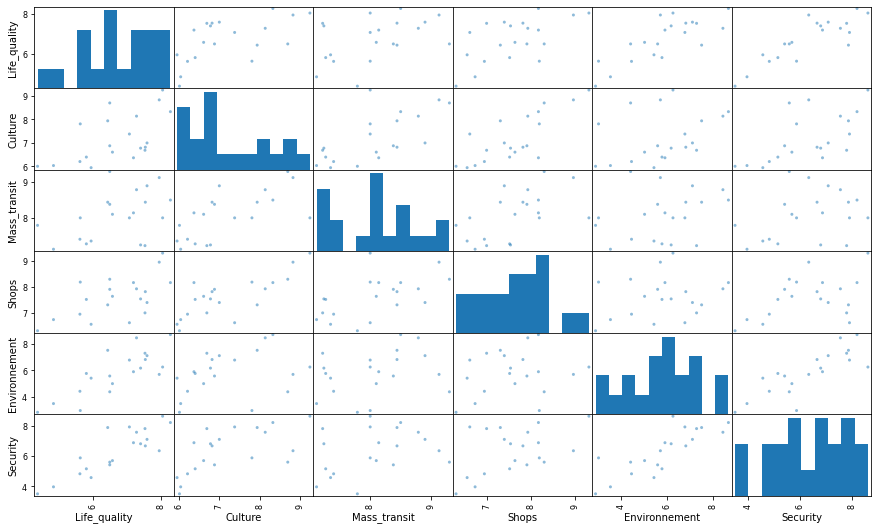

In [86]:
# Import matplotlib
import matplotlib.pyplot as plt
# Plot the scatter matrix
pd.plotting.scatter_matrix(paris_boroughs_grades_df, figsize=(15, 9))
plt.show()

### Borough Analysis:

In the **paris_boroughs_grades_df** data frame we stored grades for eah of the 20 boroughs. So how can we describe the Paris boroughs using the provided grades?

The analytic approach to solve this kind of problem is to perform a **clustering analysis** even if the dataset is rather small. For this we can use the **kMeans algorithm**.

In [5]:
paris_boroughs_grades_df.describe()

,Life_quality,Culture,Mass_transit,Shops,Environment,Security
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,6.711000,7.207000,8.075500,7.617500,5.829500,6.324000
std,1.080058,1.024069,0.665626,0.790495,1.629948,1.466968
min,4.370000,5.950000,7.120000,6.310000,2.870000,3.510000
25%,5.915000,6.392500,7.387500,6.987500,4.867500,5.355000
50%,6.830000,6.850000,8.050000,7.590000,5.835000,6.510000
75%,7.542500,7.990000,8.455000,8.170000,6.882500,7.630000
max,8.290000,9.250000,9.300000,9.310000,8.670000,8.630000


The data are in the same range (Between 0 and 10). 

To perform a clustering analysis on the dataset, we need to assess the optimal number of clusters. Findind such a optimal number is possible using the Elbow method.

To perform this task, you will find below a defined function which combine the **Elbow the silhouette methods**. 

For more details:

* On the elbow method you can follow this [link](https://pythonprogramminglanguage.com/kmeans-elbow-method/)
* On the silhouette method on [medium.com](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb) or [wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering))

In [326]:
## Elbow analysis function: With the kMeans algorithm
# The function combine the Elbow method with silhouette method
def kmeansElbow(X):
    
    #1 The required libraries:
    import numpy as np
    from sklearn.cluster import KMeans 
    from sklearn import metrics 
    from scipy.spatial.distance import cdist
    import matplotlib.pyplot as plt
    import pandas as pd
    from sklearn.metrics import silhouette_score # To find the best number of clusters

    #2 Compute the inertias and the distorsion:
    distortions = [] 
    inertias = []
    sil = []
    K = range(1,10) 

    for k in K:
        #Building and fitting the model
        kmeanModel = KMeans(n_clusters=k, random_state=0).fit(X)
        kmeanModel.fit(X)
        # Distorsion score 1:
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                            'euclidean'),axis=1)) / X.shape[0])
        # Distorsion score 2:
        inertias.append(kmeanModel.inertia_)
        
        # Computing the silhouette score:
        if (k==1):
            sil.append(0)
        else:
            sil.append(silhouette_score(X, kmeanModel.labels_, metric = 'euclidean'))

    # Storing everything back in a dataframe
    dist_iner_df = pd.DataFrame() # init
    dist_iner_df['K'] = list(K)
    dist_iner_df['Distortions'] = distortions
    dist_iner_df['inertias'] = inertias
    dist_iner_df['silhouette_score'] = sil

    # Initializing the plotting
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
    
    # Distorsion score 1 plot
    axs[0].plot(K, distortions, 'bx-') 
    axs[0].set_xlabel('Values of K') 
    axs[0].set_ylabel('Distortion') 
    axs[0].set_title('The Elbow Method using Distortion')
    
    # Distortion score 2 plot
    axs[1].plot(K, inertias, 'bx-') 
    axs[1].set_xlabel('Values of K') 
    axs[1].set_ylabel('Inertia') 
    axs[1].set_title('The Elbow Method using Inertia')
    
    # silhouette score plot
    axs[2].plot(K, sil, 'bx-') 
    axs[2].set_xlabel('Values of K') 
    axs[2].set_ylabel('Silhouette_score') 
    axs[2].set_title('The silhouette score')
    #
    plt.show()
    #
    return (dist_iner_df)

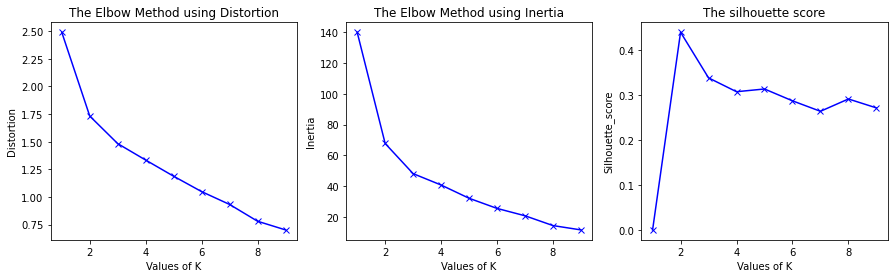

In [327]:
#1 Guetting the data and applying the function

from sklearn.preprocessing import StandardScaler
X = paris_boroughs_grades_df.iloc[:, 1:].values
X = StandardScaler().fit_transform(X)
distance_inertia_df = kmeansElbow(X)

The Silhouette Score reaches its **global maximum at the optimal k**. In our case, the optimal k is 2. Below we have the values in a tabular form as well.

In [324]:
# Elbow and silhouette score dataframe:
distance_inertia_df

,K,Distortions,inertias,silhouette_score
0,1,2.490956,140.000000,0.000000
1,2,1.732533,67.749445,0.440422
2,3,1.483025,48.156173,0.338763
3,4,1.334173,40.771434,0.307905
4,5,1.187806,32.166099,0.314000
5,6,1.048622,25.572911,0.287625
6,7,0.932411,20.791661,0.264275
7,8,0.780475,14.418950,0.291730
8,9,0.702059,11.608804,0.271886


In [6]:
# Let's create 2 clusters with the kmean algorithm:
# Libraries:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare our inputs:
X = paris_boroughs_grades_df.iloc[:, 1:].values
X_scaled = StandardScaler().fit_transform(X) # Not necessary but I kept it 
k = 2

# Perform the analysis:
borough_KMeans = KMeans(n_clusters=k).fit(X_scaled)

# Store the clusters:
paris_boroughs_grades_df['clusters'] = borough_KMeans.labels_
paris_boroughs_grades_df.head()

,Borough,Life_quality,Culture,Mass_transit,Shops,Environment,Security,clusters
0,Paris 1,6.50,8.70,9.30,8.30,4.40,5.60,1
1,Paris 2,5.63,7.81,8.00,8.19,3.00,5.88,0
2,Paris 3,8.06,9.25,8.00,9.31,6.25,8.63,1
3,Paris 4,6.44,7.94,8.44,7.31,7.50,7.88,1
4,Paris 5,8.29,8.33,8.50,8.17,8.67,8.21,1


In [19]:
# Let's regroup our data using our 2 clusters:
from IPython.display import display
pd.options.display.max_columns = None

borough_group = paris_boroughs_grades_df.groupby('clusters').agg(['count','min', 'max', 'mean'])
display(borough_group)

Life_quality                       Culture                        \
                count   min   max      mean   count   min   max      mean   
clusters                                                                    
0                   6  4.37  5.95  5.370000       6  5.95  7.81  6.403333   
1                  14  6.44  8.29  7.285714      14  6.37  9.25  7.551429   

         Mass_transit                      Shops                        \
                count   min  max      mean count   min   max      mean   
clusters                                                                 
0                   6  7.12  8.0  7.488333     6  6.31  8.19  7.045000   
1                  14  7.22  9.3  8.327143    14  6.62  9.31  7.862857   

         Environment                       Security                        
               count   min   max      mean    count   min   max      mean  
clusters                                                                   
0                  6  2.87  5.77  4.170000        6  3.51  5.88  4.655000  
1                 14  4.40  8.67  6.540714       14  5.42  8.63  7.039286

In [18]:
# Borough with lower reputation:
paris_boroughs_grades_df.loc[paris_boroughs_grades_df['clusters']==0, :]

,Borough,Life_quality,Culture,Mass_transit,Shops,Environment,Security,clusters
1,Paris 2,5.63,7.81,8.00,8.19,3.00,5.88,0
9,Paris 10,4.37,6.01,7.79,6.31,2.87,3.51,0
13,Paris 14,5.81,6.40,7.27,7.52,5.77,5.16,0
17,Paris 18,4.84,6.04,7.12,6.74,3.52,3.97,0
18,Paris 19,5.95,5.95,7.35,6.56,5.42,4.58,0
19,Paris 20,5.62,6.21,7.40,6.95,4.44,4.83,0


In [465]:
# Let's perform a hypothesis testing with t-test statistic:
cluster0_sec = paris_boroughs_grades_df.loc[paris_boroughs_grades_df['clusters']==0, 'Security']
cluster1_sec = paris_boroughs_grades_df.loc[paris_boroughs_grades_df['clusters']==1, 'Security']
cluster0_env = paris_boroughs_grades_df.loc[paris_boroughs_grades_df['clusters']==0, 'Environment']
cluster1_env = paris_boroughs_grades_df.loc[paris_boroughs_grades_df['clusters']==1, 'Environment']
# Variance computation:
print('security variance of cluster 0: ', cluster0_sec.var())
print('security variance of cluster 1: ', cluster1_sec.var())
print('security variance ratio Vmax/Vmin: ', np.max([cluster0_sec.var(), cluster1_sec.var()]) / np.min([cluster0_sec.var(), cluster1_sec.var()] ) )
#
print('Environment variance of cluster 0: ', cluster0_env.var())
print('Environment variance of cluster 1: ', cluster1_env.var())
print('Environment variance ratio Vmax/Vmin: ', np.max([cluster0_env.var(), cluster1_env.var()]) / np.min([cluster0_env.var(), cluster1_env.var()] ) )

security variance of cluster 0:  0.7144300000000001
security variance of cluster 1:  1.0338071428571431
security variance ratio Vmax/Vmin:  1.4470376983849265
Environment variance of cluster 0:  1.5353599999999996
Environment variance of cluster 1:  1.4766071428571423
Environment variance ratio Vmax/Vmin:  1.0397890917886081


In [464]:
# Hypothesis: H0: cluster0_sec_mean >= cluster1_sec_mean / Ha: cluster1_sec_mean > cluster0_sec_mean
import scipy.stats as stats
stats.ttest_ind(cluster1_sec, cluster0_sec)

Ttest_indResult(statistic=5.026272915673426, pvalue=8.771259578351774e-05)

In [466]:
# Fpr teh environment feature
stats.ttest_ind(cluster1_env, cluster0_env)

Ttest_indResult(statistic=3.9763492318763975, pvalue=0.0008852574211465035)

We can then conclude that regarding the security feature that **cluster 1 has much better security and a better environment** (more ecological) than cluster 0 (which is our alternative hypotheses).

Foe more details on [hypothesis testing](https://stackoverflow.com/questions/15984221/how-to-perform-two-sample-one-tailed-t-test-with-numpy-scipy).

### First conclusion:

From the previous exploration we saw that the were strong positive correlations between features. In addition, we can summerize the correlation matrix with the following table:

Features | Much correlated with | Less correlated with |
---------|----------------------|----------------------|
Life_Quality | Security | Mass_transit
Culture | Shops | Environment
Mass_transit | Culture | Environment
Shops | Culture | Environment
**Environment** | **Security** | **Shops** (logicaly)
**Security** | **Life_quality** |Mass_transit

From the **borough clustering**, we see that the deferentiating parameters are the **the security and the environment (green zones, cleanliness etc.)**. We can then conclude that the borough 2, 10, 14, 18, 19 and 20 (Borough in *cluster 0*) **have lower reputations than the others regarding the security, the environment and life quality**.

All the Boroughs in Paris have a good mass transit coverage.

Let's create using folium, a visual representation of Paris clusters. To do that we need the geojson file of Paris borough that we downloaded from the [airbnb data repository](http://insideairbnb.com/get-the-data.html).

In [8]:
# Little exploration of the geojson file:
import json
with open('paris_neighbourhoods.geojson') as json_data:
    paris_data = json.load(json_data)
#
paris_data['features'][0].keys()

dict_keys(['type', 'geometry', 'properties'])

In [9]:
# Extracting the borough  names:
names=[]
for i in range(20):
    names.append(paris_data['features'][i]['properties']['neighbourhood'])
# A borough name
names[0]

'Batignolles-Monceau'

In [10]:
# Number of boroughs in the file:
len(paris_data['features'])

20

In [34]:
#int(paris_boroughs_grades_df.Borough[0].split()[-1])

In [35]:
# Creating a dataframe with borough name and linked cluster:
boroughs_name = pd.read_csv("paris_neighbourhoods_1.csv")
# cleaning
boroughs_name.drop(columns=['neighbourhood_group'], inplace=True)
# sorting & cleaning
boroughs_name = boroughs_name.sort_values(['Number'])
boroughs_name.reset_index(inplace=True)
boroughs_name.drop(columns=['index'], inplace=True)
# adding the previously defined clusters
boroughs_name['clusters'] = paris_boroughs_grades_df['clusters']
# dataframe view:
boroughs_name.head()

,neighbourhood,Number,clusters
0,Louvre,1,1
1,Bourse,2,0
2,Temple,3,1
3,Hôtel-de-Ville,4,1
4,Panthéon,5,1


In [45]:
# Paris latitude and longitude (from general idea about Paris)

lat = 48.8589
long = 2.33828

 # geojson file
paris_geo = r'paris_neighbourhoods_1.geojson'

# create a plain world map
paris_borough_map = folium.Map(location=[lat, long], zoom_start=12)

# generate choropleth map
choropleth = folium.Choropleth(
                    geo_data=paris_geo,
                    data = boroughs_name,
                    columns=['neighbourhood', 'clusters'],
                    key_on='feature.properties.neighbourhood',
                    fill_color='YlGn',
                    fill_opacity=0.7, 
                    line_opacity=0.2,
                    legend_name='Paris borough clusters',    
                    highlight=True,
                    line_color = 'black'
                                ).add_to(paris_borough_map)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['neighbourhood'],labels=False)
)

# display map
paris_borough_map

We can see above in green the the borough with good reputation **(security + environment)**.

In [37]:
# Adding security to boroughs_names:
boroughs_name['security'] = paris_boroughs_grades_df['Security']
boroughs_name.head()

,neighbourhood,Number,clusters,security
0,Louvre,1,1,5.60
1,Bourse,2,0,5.88
2,Temple,3,1,8.63
3,Hôtel-de-Ville,4,1,7.88
4,Panthéon,5,1,8.21


In [511]:
# Boroughs with security issues
# Paris latitude and longitude (from general idea about Paris)

lat = 48.8589
long = 2.33828

 # geojson file
paris_geo = r'paris_neighbourhoods_1.geojson'

# create a plain world map
paris_borough_map_cluster_0 = folium.Map(location=[lat, long], zoom_start=12)

# generate choropleth map
choropleth = folium.Choropleth(
                    geo_data=paris_geo,
                    data = boroughs_name[boroughs_name['clusters']==0],
                    columns=['neighbourhood', 'security'],
                    key_on='feature.properties.neighbourhood',
                    fill_color='YlOrRd',
                    fill_opacity=0.7, 
                    line_opacity=0.2,
                    legend_name='Security grades in cluster 0 (less popular boroughs)',    
                    highlight=True,
                    line_color = 'black'
                                ).add_to(paris_borough_map_cluster_0)

choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['neighbourhood'],labels=False) )

# display map
paris_borough_map_cluster_0

And if we focus for example on boroughs with security issues, we see above that **Entrepot** is the **least secure** and that the latter is **closer to "Bourse" which is the most secure** in the cluster of the less popular boroughs regarding the security.

## 5. Paris Neighborhoods exploration <a name="venues"></a>

Now that we have a general idea on Paris and a view on general boroughs reputation, we can try to understand more the neighbourhoods. In this section, we will perform a segmentation to categorize neighbourhoods.

To do that, let's first get the neighbourhoods location data from an open data repository and clean the data. Secondly, we will use the Foursquare API to get famous venues each neighbourhoods.

### Getting the data:

In [59]:
# Source: https://opendata.paris.fr/explore/dataset/quartier_paris/table/
# Source telechargement: 
neighbourhoods_link = 'https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B'
paris_neighborhoods_df = pd.read_csv(neighbourhoods_link, sep=';')
paris_neighborhoods_df.head()

,N_SQ_QU,C_QU,C_QUINSEE,L_QU,C_AR,N_SQ_AR,PERIMETRE,SURFACE,Geometry X Y,Geometry
0,750000015,15,7510403,Arsenal,4,750000004,2878.559656,4.872649e+05,"48.851585175,2.36476795387","{""type"": ""Polygon"", ""coordinates"": [[[2.368512..."
1,750000018,18,7510502,Jardin-des-Plantes,5,750000005,4052.729521,7.983894e+05,"48.8419401934,2.35689388962","{""type"": ""Polygon"", ""coordinates"": [[[2.364561..."
2,750000039,39,7511003,Porte-Saint-Martin,10,750000010,3245.891413,6.090347e+05,"48.8712446509,2.36150364735","{""type"": ""Polygon"", ""coordinates"": [[[2.363917..."
3,750000043,43,7511103,Roquette,11,750000011,4973.010557,1.172087e+06,"48.8570640408,2.38036406173","{""type"": ""Polygon"", ""coordinates"": [[[2.379720..."
4,750000046,46,7511202,Picpus,12,750000012,18261.910318,7.205014e+06,"48.8303592424,2.42882681508","{""type"": ""Polygon"", ""coordinates"": [[[2.411249..."


In [51]:
paris_neighborhoods_df.shape

(80, 10)

From the data, let's clean the dataframe.

### Data Wrangling:

In [60]:
# Selecting the columns to keep
paris_neighborhoods_df = paris_neighborhoods_df[['C_AR', 'C_QU', 'L_QU', 'Geometry X Y', 'C_QUINSEE']].sort_values('C_AR')
# English column translation
paris_neighborhoods_df.columns = ['borough_number', 'neighbourhood_number', 'neighbourhood_name', 'Lat_Lng', 'INSEE_ID']
paris_neighborhoods_df.head()

,borough_number,neighbourhood_number,neighbourhood_name,Lat_Lng,INSEE_ID
58,1,3,Palais-Royal,"48.8646599781,2.33630891897",7510103
35,1,1,Saint-Germain-l'Auxerrois,"48.8606501352,2.33491032928",7510101
13,1,2,Halles,"48.8622891081,2.34489885831",7510102
16,1,4,Place-Vendôme,"48.8670185906,2.32858166493",7510104
72,2,8,Bonne-Nouvelle,"48.8671501183,2.35008019041",7510204


In [61]:
# splitting the coordinates
coord = paris_neighborhoods_df.loc[:, 'Lat_Lng'].apply(lambda x: x.split(','))
# Storing coordinates in lists
Lat=[]
Lng=[]
for elt in coord:
    Lat.append(elt[0])
    Lng.append(elt[1])
# storing coordinates in the dataframe
paris_neighborhoods_df['Lat'] = [float(x) for x in Lat]
paris_neighborhoods_df['Lng'] = [float(x) for x in Lng]
#
paris_neighborhoods_df.head()

,borough_number,neighbourhood_number,neighbourhood_name,Lat_Lng,INSEE_ID,Lat,Lng
58,1,3,Palais-Royal,"48.8646599781,2.33630891897",7510103,48.864660,2.336309
35,1,1,Saint-Germain-l'Auxerrois,"48.8606501352,2.33491032928",7510101,48.860650,2.334910
13,1,2,Halles,"48.8622891081,2.34489885831",7510102,48.862289,2.344899
16,1,4,Place-Vendôme,"48.8670185906,2.32858166493",7510104,48.867019,2.328582
72,2,8,Bonne-Nouvelle,"48.8671501183,2.35008019041",7510204,48.867150,2.350080


In [62]:
# cleaning the data frame:
paris_neighborhoods_df = paris_neighborhoods_df.drop(columns='Lat_Lng')
paris_neighborhoods_df = paris_neighborhoods_df.reset_index(drop=True)
paris_neighborhoods_df.head()

,borough_number,neighbourhood_number,neighbourhood_name,INSEE_ID,Lat,Lng
0,1,3,Palais-Royal,7510103,48.864660,2.336309
1,1,1,Saint-Germain-l'Auxerrois,7510101,48.860650,2.334910
2,1,2,Halles,7510102,48.862289,2.344899
3,1,4,Place-Vendôme,7510104,48.867019,2.328582
4,2,8,Bonne-Nouvelle,7510204,48.867150,2.350080


In [66]:
paris_neighborhoods_df = paris_neighborhoods_df.sort_values(['borough_number', 'neighbourhood_number'])
paris_neighborhoods_df = paris_neighborhoods_df.reset_index(drop=True)
paris_neighborhoods_df.head()

,borough_number,neighbourhood_number,neighbourhood_name,INSEE_ID,Lat,Lng
0,1,1,Saint-Germain-l'Auxerrois,7510101,48.860650,2.334910
1,1,2,Halles,7510102,48.862289,2.344899
2,1,3,Palais-Royal,7510103,48.864660,2.336309
3,1,4,Place-Vendôme,7510104,48.867019,2.328582
4,2,5,Gaillon,7510201,48.869307,2.333432


### Guetting Famous venues with Foursquare:

In [84]:
# Libraries
import requests
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [71]:
# fourquare credential:
F_cred = pd.read_csv("Foursquare_Personnal_ID.csv")
F_cred.columns

Index(['CLIENT_ID ', 'CLIENT_SECRET'], dtype='object')

In [98]:
# guetting personnal ID
CLIENT_ID, CLIENT_SECRET, VERSION, LIMIT = F_cred['CLIENT_ID '][0].split()[-1] , F_cred.CLIENT_SECRET[0], '20180605', 100 #Default Foursquare limit
print('credentials Imported!')

credentials Imported!


The function below is designed to extract venue categories from framous venues in a 500m radius.

In [101]:
# Let's reuse the functon below for venue
def getNearbyVenues(CLIENT_ID, CLIENT_SECRET, VERSION, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print('.')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results]) # will create a list of lists

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])        
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [522]:
# Create the dataframe venues
paris_venues = getNearbyVenues(CLIENT_ID, CLIENT_SECRET, VERSION, paris_neighborhoods_df['neighbourhood_name'], 
                                   paris_neighborhoods_df['Lat'], paris_neighborhoods_df['Lng'], radius=500)
# paris_venues shape
print('All Done!')
# Showing the dimension
print(paris_venues.shape)
#
paris_venues.head()

All Done!
(5307, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Saint-Germain-l'Auxerrois,48.86065,2.33491,Musée du Louvre,48.860847,2.336440,Art Museum
1,Saint-Germain-l'Auxerrois,48.86065,2.33491,La Vénus de Milo (Vénus de Milo),48.859943,2.337234,Exhibit
2,Saint-Germain-l'Auxerrois,48.86065,2.33491,Vestige de la Forteresse du Louvre,48.861577,2.333508,Historic Site
3,Saint-Germain-l'Auxerrois,48.86065,2.33491,Cour Napoléon,48.861172,2.335088,Plaza
4,Saint-Germain-l'Auxerrois,48.86065,2.33491,"Pavillon des Sessions – Arts d'Afrique, d'Asie...",48.860724,2.332121,Art Museum


In [523]:
paris_venues.loc[paris_venues['Venue Category'] == 'Plaza', :]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,Saint-Germain-l'Auxerrois,48.860650,2.334910,Cour Napoléon,48.861172,2.335088,Plaza
6,Saint-Germain-l'Auxerrois,48.860650,2.334910,Place du Palais Royal,48.862523,2.336688,Plaza
15,Saint-Germain-l'Auxerrois,48.860650,2.334910,Place Colette,48.863145,2.335943,Plaza
23,Saint-Germain-l'Auxerrois,48.860650,2.334910,Place des Pyramides,48.863924,2.332224,Plaza
25,Saint-Germain-l'Auxerrois,48.860650,2.334910,Place du Louvre,48.859841,2.340822,Plaza
...,...,...,...,...,...,...,...
5150,Combat,48.878639,2.380127,Square Bolivar,48.875911,2.381618,Plaza
5219,Saint-Fargeau,48.871035,2.406172,Place Saint-Fargeau,48.870980,2.403679,Plaza
5229,Père-Lachaise,48.863719,2.395273,Place Gambetta,48.864915,2.398482,Plaza
5231,Père-Lachaise,48.863719,2.395273,Place Martin Nadaud,48.864983,2.394750,Plaza


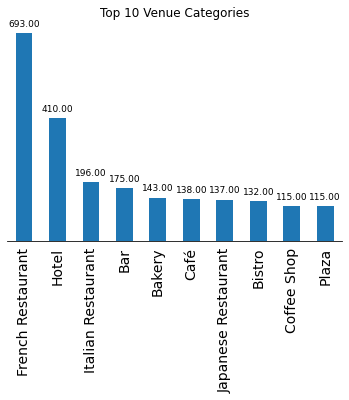

In [524]:
# Lets's view the first categories:
ax = paris_venues['Venue Category'].value_counts()[0:10].plot(kind='bar')
plt.title("Top 10 Venue Categories")

# Add the percentage values on bar tops:
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                   ( p.get_x() + p.get_width() / 2., p.get_height() ), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points', size = 9)

# Hide axis:
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
#
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True, labelsize=14)
#
plt.show()

It is impressive to see that **the first category is French restaurant** with about 693 french restaurants in Paris. We can also see that among the top 10 venue categories in Paris, there is italian restaurant, bar, café, bakery and plaza.

We may wonder about the different kinds of restaurants.

In [525]:
# Lets's find out the different kind of restaurants:
# Key words
word = 'Restaurant'
# Finding restaurants indexes
cond = paris_venues['Venue Category'].str.contains(word)
# Findind the total restaurant number
N_restaurants = paris_venues.loc[cond, 'Venue Category'].value_counts().sum()
# list of restaurant type with frequence linked to each:
paris_venues.loc[cond, 'Venue Category'].value_counts() / N_restaurants

French Restaurant                  0.378275
Italian Restaurant                 0.106987
Japanese Restaurant                0.074782
Restaurant                         0.046943
Chinese Restaurant                 0.028384
                                     ...   
Indonesian Restaurant              0.000546
Southern / Soul Food Restaurant    0.000546
Ch'ti Restaurant                   0.000546
Caribbean Restaurant               0.000546
Molecular Gastronomy Restaurant    0.000546
Name: Venue Category, Length: 82, dtype: float64

In [526]:
# how many kind of restaurants:
print('There are {} kinds of restaurants in Paris'.format(len(paris_venues.loc[cond, 'Venue Category'].unique())))

There are 82 kinds of restaurants in Paris


Now we can answer to our latter question. There are 82 kinds of restaurants and **French Restaurants** represent about 38% of all restaurants in Paris.

Now, what is the most represented neighbourhood?

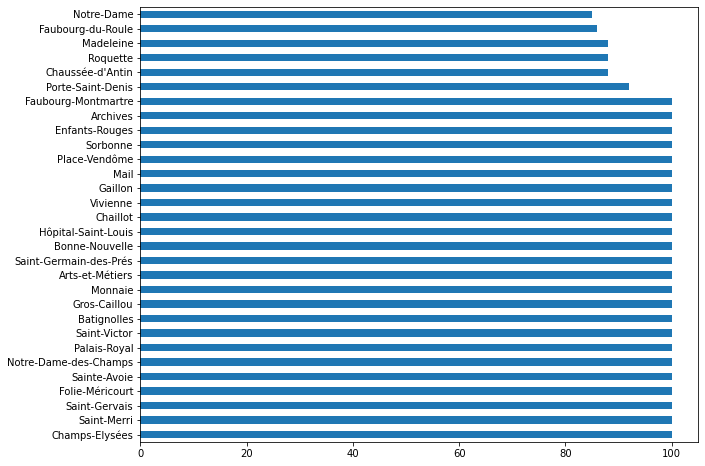

In [527]:
paris_venues['Neighborhood'].value_counts()[0:30].plot(kind='barh', figsize=(10, 8))
plt.show()

### Feature Engineering: One Hot encoding

In [528]:
# one hot encoding: Creating the dummie Data Frame
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

# Reorder the columns moving neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Locksmith,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Martial Arts School,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Resort,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Fair,Supermarket,Sushi Restaurant,Sy

In [529]:
# Let's group the neighborhood
paris_grouped = paris_onehot.groupby('Neighborhood').sum().reset_index()
#
paris_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Locksmith,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Martial Arts School,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Resort,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Fair,Supermarket,Sushi Restaurant,Sy

In [530]:
paris_grouped.shape

(80, 308)

In [495]:
paris_grouped.iloc[:, 1:]

,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Locksmith,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Martial Arts School,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Resort,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Fair,Supermarket,Sushi Restaurant,Syrian Restaura

### Clusters number selection:

In [531]:
# Selecting the data
Y = paris_grouped.iloc[:, 1:]
# Scaling the data:
Y_scaled = StandardScaler().fit_transform(Y)

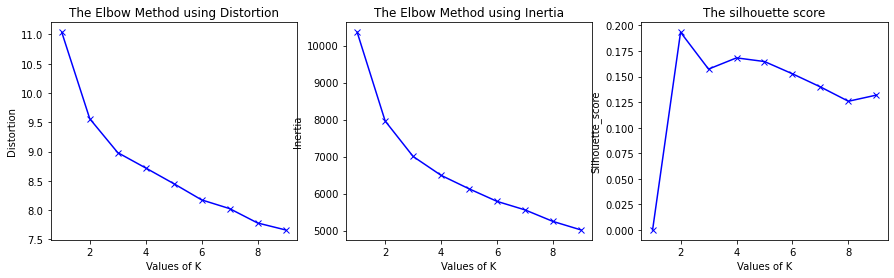

In [532]:
# Applying the function
distance_inertia_df2 = kmeansElbow(Y)

The optimal cluster number is 2, but we will use 3 for a better exploration in the next part.

### Paris clustering analysis:

In [533]:
## 1: Cluster analysis

# set number of clusters
kclusters = 3

# run k-means clustering
paris_neighborhood_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Y_scaled)

# check cluster labels generated for each row in the dataframe
paris_neighborhood_kmeans.labels_[0:10]

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0])

In [534]:
## 2: Data Gathering
paris_grouped_dup = paris_grouped
try:
    paris_grouped_dup.drop(columns=['Cluster Labels'], inplace=True)
except: None
#
# add clustering labels
paris_grouped_dup.insert(0, 'Cluster Labels', paris_neighborhood_kmeans.labels_)

paris_grouped_dup.head()

,Cluster Labels,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Locksmith,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Martial Arts School,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Resort,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Fair,Supermarket,Sush

In [535]:
paris_grouped_dup.groupby(['Cluster Labels']).agg(['count']) #mean().T.sort_values([0, 1],ascending=False)

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Locksmith,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Martial Arts School,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Resort,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Fair,Supermarket,Sushi Restaurant,Sy

In [536]:
# Cluster 3 composition (The categories are on rows)
ind = paris_grouped_dup.loc[paris_grouped_dup['Cluster Labels'] == 2, :].index.tolist()
paris_grouped_dup.iloc[ind, 2:].sum().sort_values(ascending=False)

Japanese Restaurant          32
French Restaurant            22
Hotel                        20
Wine Bar                     11
Coffee Shop                  10
                             ..
Mobile Phone Shop             0
Miscellaneous Shop            0
Middle Eastern Restaurant     0
Metro Station                 0
Accessories Store             0
Length: 307, dtype: int64

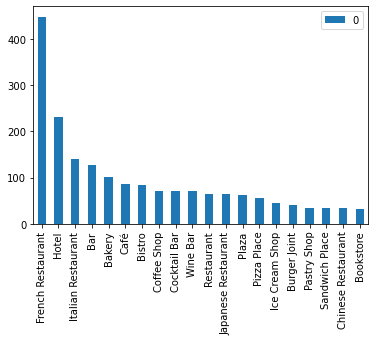

In [537]:
# Composition cluster 0
paris_grouped.groupby(['Cluster Labels']).sum().iloc[0, 0:].sort_values(ascending=False)[0:20].to_frame().plot(kind='bar')
plt.show()

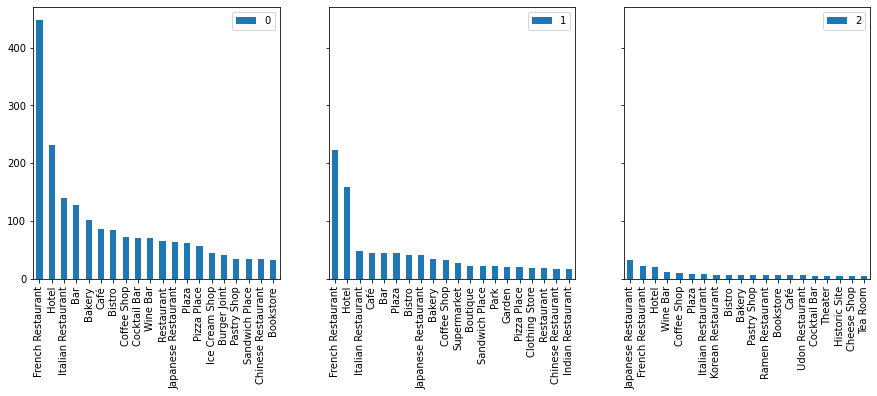

In [538]:
# Clusters comparison
fig, axes = plt.subplots(1, len(paris_grouped_dup['Cluster Labels'].unique()), figsize=(15, 5), sharey=True)

# Composition cluster 0
paris_grouped.groupby(['Cluster Labels']).sum().iloc[0, 0:].sort_values(ascending=False)[0:20].to_frame().plot(kind='bar', 
                                                                                                                ax=axes[0])
# Composition cluster 1
paris_grouped.groupby(['Cluster Labels']).sum().iloc[1, 0:].sort_values(ascending=False)[0:20].to_frame().plot(kind='bar',
                                                                                                               ax=axes[1])
# Composition cluster 2
paris_grouped.groupby(['Cluster Labels']).sum().iloc[2, 0:].sort_values(ascending=False)[0:20].to_frame().plot(kind='bar',
                                                                                                               ax=axes[2])

plt.show()

Above we have the most represented venue categories in each clusters.

We can see that the difference is mainly in the density of each category:

* cluster 0: high density shops (restaurants, hotels, bars, bakery and café categories) with plaza and bookstore.
* cluster 1: medium density shops (restaurants, hotels, bars) with plaza, parks and gardens.
* cluster 2: low densisty shop (mostly restaurants and hotels) with book store, historic sites and thearters.

The cluster 2 has the lowest competition and restaurant are mostly asian.

### Restaurants distribution in clusters:

French Restaurant                37.302248
Italian Restaurant               11.656953
Restaurant                        5.412157
Japanese Restaurant               5.328893
Chinese Restaurant                2.914238
Seafood Restaurant                2.414654
Vietnamese Restaurant             2.414654
Thai Restaurant                   2.414654
Vegetarian / Vegan Restaurant     2.248127
Asian Restaurant                  1.998335
Name: 0, dtype: float64


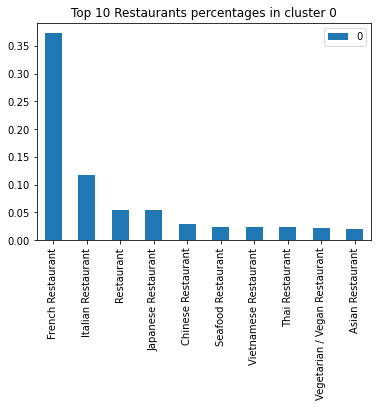

In [477]:
# Restaurant in cluster 0:
# Key words
word = 'Restaurant'
# Finding restaurants indexes
ind = paris_grouped.groupby(['Cluster Labels']).sum().iloc[0, 0:].index.str.contains(word)
# Finding the total number of restaurant in the cluster
c1_resto = sum(paris_grouped.groupby(['Cluster Labels']).sum().iloc[0, 0:][ind])
# Computing percentage
p1_resto = paris_grouped.groupby(['Cluster Labels']).sum().iloc[0, 0:][ind].sort_values(ascending=False) / c1_resto
print(p1_resto[0:10]*100) # print of teh percentages
# plotting the result
p1_resto[0:10].to_frame().plot(kind='bar')
plt.title('Top 10 Restaurants percentages in cluster 0')
plt.show()

In cluster 0 among the top 10 restaurants:
> * French restaurant is the major restaurant category (37% of all restaurants)
> * Asian (japanese, Chinesen Vietnamese, Thaï etc.) (about 14%)
> * Italian (about 12%).

French Restaurant        42.476190
Italian Restaurant        9.142857
Japanese Restaurant       7.809524
Restaurant                3.619048
Indian Restaurant         3.238095
Chinese Restaurant        3.238095
Vietnamese Restaurant     2.857143
Asian Restaurant          2.857143
Sushi Restaurant          2.666667
Thai Restaurant           2.476190
Name: 1, dtype: float64


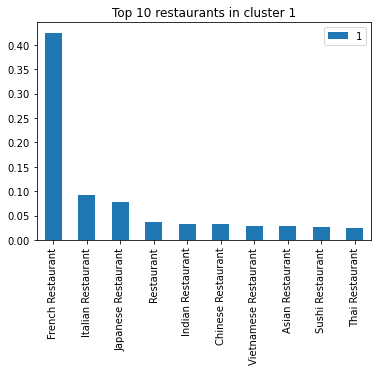

In [452]:
# Restaurant in cluster 1:
# Key words
word = 'Restaurant'
# Cluster number
k = 1
# Cluster group
clustg = paris_grouped.groupby(['Cluster Labels']).sum().iloc[k, 0:]
# Finding restaurants indexes in cluster 1
ind = clustg.index.str.contains(word)
# Finding the total number of restaurant in the cluster
c1_resto = sum(clustg[ind])
# Computing percentage
p1_resto = clustg[ind].sort_values(ascending=False) / c1_resto
print(p1_resto[0:10]*100) # print of teh percentages
# plotting the result
p1_resto[0:10].to_frame().plot(kind='bar')
plt.title('Top 10 restaurants in cluster 1')
plt.show()

Among the top 10 restaurants in the cluster 1 (MEDIUM density shop) we have the following composition: 
> * French restaurants with about 42.5%
> * Asian with about 45% 
> * Italian with about 9%. 

So there is more asian restaurants in cluster 1.

Japanese Restaurant      30.188679
French Restaurant        20.754717
Italian Restaurant        7.547170
Korean Restaurant         6.603774
Udon Restaurant           5.660377
Ramen Restaurant          5.660377
Asian Restaurant          2.830189
Taiwanese Restaurant      2.830189
Sushi Restaurant          2.830189
Vietnamese Restaurant     1.886792
Name: 2, dtype: float64


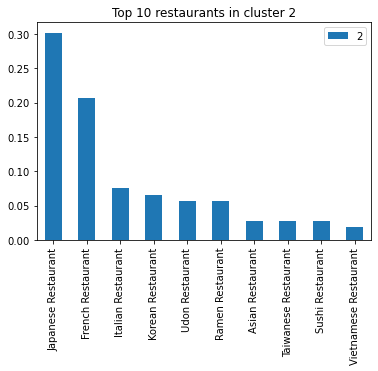

In [456]:
# Restaurant in cluster 2:
# Key words
word = 'Restaurant'
# Cluster number
k = 2
# Cluster group
clustg = paris_grouped.groupby(['Cluster Labels']).sum().iloc[k, 0:]
# Finding restaurants indexes in cluster 1
ind = clustg.index.str.contains(word)
# Finding the total number of restaurant in the cluster
c1_resto = sum(clustg[ind])
# Computing percentage
p1_resto = clustg[ind].sort_values(ascending=False) / c1_resto
print(p1_resto[0:10]*100) # print of teh percentages
# plotting the result
p1_resto[0:10].to_frame().plot(kind='bar')
plt.title('Top 10 restaurants in cluster 2')
plt.show()

In cluster 2, asian restaurants represent the first restaurant category (62%), followed by french (about 30%) and italian (about 8%).

So when the competition decrease, asian restaurants tend to work their way to the up.

### Folium clusters visualisation:

In [430]:
# Adding the Lat, Lng and borough_number to paris_grouped_dup:
Lat = []
Lng = []
borough_number = []

for elt in paris_grouped_dup['Neighborhood']:
    word = elt
    cond = paris_neighborhoods_df['neighbourhood_name'].str.contains(word)
    borough_number.append(paris_neighborhoods_df.loc[cond, 'borough_number'].values[0])
    Lat.append(paris_neighborhoods_df.loc[cond, 'Lat'].values[0])
    Lng.append(paris_neighborhoods_df.loc[cond, 'Lng'].values[0])

# inserting elements in paris_grouped_dup
paris_grouped_dup.insert(0, 'borough_number', borough_number)
paris_grouped_dup.insert(2, 'Lat', Lat)
paris_grouped_dup.insert(3, 'Lng', Lng)

paris_grouped_dup.head()

,borough_number,Cluster Labels,Lat,Lng,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Locksmith,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Martial Arts School,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Resort,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Stree

In [438]:
# create map
latitude = 48.8589
longitude = 2.33828
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
import matplotlib.cm as cm
from matplotlib.colors import to_hex
from matplotlib import colors
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = [to_hex(i) for i in colors_array] # works as well!!


# add markers to the map
for lat, lon, poi, cluster, borough in zip(paris_grouped_dup['Lat'], 
                                           paris_grouped_dup['Lng'], 
                                           paris_grouped_dup['Neighborhood'], 
                                           paris_grouped_dup['Cluster Labels'],
                                           paris_grouped_dup['borough_number']):
    #
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + '\n' + 'Paris' + str(borough), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

    # plotting the map
map_clusters

Regarding the neighborhood clustering analysis, we observe:

>* cluster 0 (In red): high density for restaurants (french, italian) and hotels
>* cluster 1 (purple): medium density fort restaurants and hotels
>* cluster 2 (in green):  low density (mostly asian, french and italian restaurants)

The clustering analysis also shows that, right **at the middle of Paris** there is the **lowest french restaurants density** but the highest asian restaurants. Famous venues are mainly shops, hotel, café, bar and plaza. This is probably because there are many company headquarters and then customers in Paris.

## 6. Results and discussion <a name="discussion"></a>

In [439]:
# Paris latitude and longitude (from general idea about Paris)

lat = 48.8589
long = 2.33828

 # geojson file
paris_geo = r'paris_neighbourhoods_1.geojson'

# create a plain world map
paris_borough_map = folium.Map(location=[lat, long], zoom_start=12)

# generate choropleth map
choropleth = folium.Choropleth(
                    geo_data=paris_geo,
                    data = boroughs_name,
                    columns=['neighbourhood', 'clusters'],
                    key_on='feature.properties.neighbourhood',
                    fill_color='YlGn',
                    fill_opacity=0.7, 
                    line_opacity=0.2,
                    legend_name='Paris borough clusters',    
                    highlight=True,
                    line_color = 'black'
                                ).add_to(paris_borough_map)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['neighbourhood'],labels=False)
)

# add markers to the map
for lat, lon, poi, cluster, borough in zip(paris_grouped_dup['Lat'], 
                                           paris_grouped_dup['Lng'], 
                                           paris_grouped_dup['Neighborhood'], 
                                           paris_grouped_dup['Cluster Labels'],
                                           paris_grouped_dup['borough_number']):
    #
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + '\n' + 'Paris' + str(borough), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(paris_borough_map)

# display map
paris_borough_map

Looking at the above map and the clusters compositions we see that we have a higher shop density in the most secure borough cluster. The shops density is rather high in these boroughs. Nevertheless, shops density in boroughs with less reputation appear to be rather medium and not low at all. 

Shops appear to be much concentrated around the Paris center. The competition at the center of Paris is then more important and especially for french, italian and finally asian specialties.

However, we can see that <span style="color:blue">*Passy*</span> and <span style="color:blue">*Reuilly*</span> boroughs (12th and 16th boroughs) have both a medium shop density, a good reputation and more important surface. This could represent an opportunity for a restaurant owner as the neighbourhoods are distant from one another.


At the beginning of these study we didn't really know a single think about Paris. 

The study provided information about the general reputation of Paris boroughs and about the level of competition in each neighbourhoods. We have also seen that the accessibility is not really an issue since the mass transit coverage appear to be rather good all over Paris. But regarding the boroughs, the security and environmental considerations are divisive.

Looking at the last Paris map, a business owner could have different strategies according to his \ her preferences:

> - A strategy could be to go into higher density neighbourhoods with aggressive prices trying to compete or with not well represented restaurant specialties like Caribbean \ African or Mexican.
>
> - Another way could be to develop a new concept of restaurant in lower shop density neighbourhood (like righ in the middle of Paris).
>
> - As stated before, the 12th and the 16th Paris boroughs appear to be large enough with rather medium shop density neighbourhoods, so the opportunity there would be high.
>
> - Finally, we have seen that in each neighborhoods clusters there are plazas that could be used (if allowed by the town hall) for a food truck approach.

The later option could be competitive enough especially if combined for example, with the localization of a web application to guide customers to the foodtruck.



## 7. Conclusion <a name="conclusion"></a>

Our objective was to find the best place to open a restaurant in Paris. So first we had to choose a set of parameters to define what a best place could be. As parameters we selected the general reputation (as a combination of security, the accessibility, quality of life and others) and the level of competition. Of course these are not all the relevant parameters, even if the later are the first to consider before going further.

Having the selected parameters in mind we extracted data from web pages on internet (directly downloading dataset or web-scraping web pages) mainly about Paris itself, Paris boroughs notations and Paris neighbourhoods locations. After cleaning, we used the collected data to build clusterings analyses with the KMeans algorithm as a descriptive approach.

The analyses allowed to divide Paris boroughs according to the reputation and Paris neighbourhoods according to the shop density. The location data combined with the latter Paris subdivisions allowed to represent all of the clusters on a Paris map for visualisation. 

Our results was to show how Paris could be divided and to draft some strategies for potential business owners according to the identified clusters. Globally everything depends on the marketing mix the business owner wants to apply: he could be aggressive with prices in high density neighborhoods or be a niche player targeting not enough represented specialties.

However, this study is only the beginning. We mean that there are a lot more parameters to define a best place and then to address the problematic. To continue the work we could gather more information about shops in each neighbourhoods. We could also (with a Foursquare Paid account) collect more information about restaurants (tips, ratings and more) to be more specific about the strategy and obviouly know more about shops clients. 

An important aspect that we didn't mentioned is the Paris demography. The business owner will need to know more about potential clients to work on its marketing positioning. 

But everything and every study needs a ends for a new beginning so I thank you for your attention and hope I have given you valuable insights for your idea to come true.

[Back to Table of contents](#table)
___